# Exporting Replicated Instance Data for Analytics

This project documents and end-to-end workflow for 

1. querying replicated instance event history from the API
3. Doing some simple visualizations
4. Loading the data into a SQL database
5. Querying it back out for analysis

In [141]:
import json

with open("config.json") as configfile:
    config = json.load(configfile)

REPLICATED_API_TOKEN = config["REPLICATED_API_TOKEN"]
REPLICATED_APP_ID = config["REPLICATED_APP_ID"]

### Fetching an instance

In [142]:
import requests

resp = requests.get(
    f"https://api.replicated.com/vendor/v3/app/{REPLICATED_APP_ID}/customer_instances?format=json",
    headers=dict(Authorization=REPLICATED_API_TOKEN),
)

customers = resp.json()

instance = customers[0]["instances"][1]

instance





{'instanceId': '2Rq9aF4aVAHozi9JL8CZKkcPvqw',
 'isActive': True,
 'firstReportedAt': '2023-06-28T15:40:17.451Z',
 'lastReportedAt': '2023-10-20T16:32:43.223Z',
 'firstReadyAt': '2023-07-09T17:09:22.418Z',
 'kotsVersion': 'v1.101.1',
 'k8sVersion': 'v1.26.6-gke.1700',
 'isAirgap': False,
 'isKurl': False,
 'lastAppStatus': 'ready',
 'client': 'KOTS',
 'kurlNodeCountTotal': 0,
 'kurlNodeCountReady': 0,
 'cloudProvider': 'gcp',
 'cloudProviderRegion': 'us-central1',
 'versionLabel': '1.14.0',
 'versionAge': 63,
 'isGitOpsEnabled': False,
 'gitopsProvider': '',
 'isSkipPreflights': False,
 'preflightStatus': 'fail',
 'k8sDistribution': 'gke',
 'customMetricsReportedAt': None,
 'customMetricsData': None}

### Fetching events for the instance

In [143]:

resp = requests.get(
    f"https://api.replicated.com/v1/instance/{instance['instanceId']}/events",
    headers=dict(Authorization=REPLICATED_API_TOKEN),
)

events = resp.json()

# preview one event
events['events'][0]

{'reportedAt': '2023-10-20T16:32:43.223Z',
 'fieldName': 'appStatus',
 'isCustom': False,
 'previousValue': 'degraded',
 'newValue': 'ready',
 '_embedded': None,
 '_resources': {'_self': {'href': '/v1/instance-event/2023-10-20 16:32:43.223 +0000 UTC',
   'method': 'GET',
   'documentation': 'https://replicated-vendor-api.readme.io/v4/reference/getinstanceevent'}}}

### Collecting all AppVersion Events

In [120]:
def clean_filter_events(events, fieldName=None):
    return [
        {k : event[k] for k in {'newValue', 'reportedAt'}} for event in events['events']
        if fieldName is None or event['fieldName'] == fieldName
    ]

appVersionEvents = clean_filter_events(events, 'k8sVersion')
appVersionEvents

[{'newValue': 'v1.26.6-gke.1700', 'reportedAt': '2023-09-12T08:14:09.33Z'},
 {'newValue': 'v1.26.5-gke.2700', 'reportedAt': '2023-08-19T07:21:04.573Z'},
 {'newValue': 'v1.26.5-gke.1400', 'reportedAt': '2023-07-31T12:37:01.403Z'},
 {'newValue': 'v1.25.10-gke.1400', 'reportedAt': '2023-07-29T11:55:50.347Z'},
 {'newValue': 'v1.25.10-gke.1200', 'reportedAt': '2023-07-14T09:20:01.244Z'},
 {'newValue': 'v1.25.9-gke.2300', 'reportedAt': '2023-07-01T14:26:01.208Z'},
 {'newValue': 'v1.24.12-gke.1000', 'reportedAt': '2023-06-28T15:40:17.451Z'}]

### Exploring for all customer instances

In [121]:
print(f"customers: {len(customers)}")

customers: 4


In [122]:
allInstances = [instance for instance in customer['instances'] for customer in customers]
                        
print(f"instances: {len(allInstances)}")

instances: 12


### Add version label events to a single instance

In [124]:
def add_events(instance, fieldName=None):
    resp = requests.get(
        f"https://api.replicated.com/v1/instance/{instance['instanceId']}/events",
        headers=dict(Authorization=REPLICATED_API_TOKEN),
    )

    events = resp.json()
    instance['events'] = clean_filter_events(events, fieldName)
    return instance

add_events(allInstances[2], 'k8sVersion')


{'instanceId': '2Rq9aF4aVAHozi9JL8CZKkcPvqw',
 'isActive': True,
 'firstReportedAt': '2023-06-28T15:40:17.451Z',
 'lastReportedAt': '2023-10-20T16:32:43.223Z',
 'firstReadyAt': '2023-07-09T17:09:22.418Z',
 'kotsVersion': 'v1.101.1',
 'k8sVersion': 'v1.26.6-gke.1700',
 'isAirgap': False,
 'isKurl': False,
 'lastAppStatus': 'ready',
 'client': 'KOTS',
 'kurlNodeCountTotal': 0,
 'kurlNodeCountReady': 0,
 'cloudProvider': 'gcp',
 'cloudProviderRegion': 'us-central1',
 'versionLabel': '1.14.0',
 'versionAge': 63,
 'isGitOpsEnabled': False,
 'gitopsProvider': '',
 'isSkipPreflights': False,
 'preflightStatus': 'fail',
 'k8sDistribution': 'gke',
 'customMetricsReportedAt': None,
 'customMetricsData': None,
 'events': [{'newValue': 'v1.26.6-gke.1700',
   'reportedAt': '2023-09-12T08:14:09.33Z'},
  {'newValue': 'v1.26.5-gke.2700', 'reportedAt': '2023-08-19T07:21:04.573Z'},
  {'newValue': 'v1.26.5-gke.1400', 'reportedAt': '2023-07-31T12:37:01.403Z'},
  {'newValue': 'v1.25.10-gke.1400', 'reported

In [198]:
# invert index from instance->event to event->instance
import datetime

def generate_inverted_events(instances, fieldName=None):
    for instance in instances:
        instance_with_events = add_events(instance, fieldName)
        for event in instance_with_events['events']:
            event['instanceId'] = instance['instanceId']
            event['reportedAt'] = datetime.datetime.strptime(event['reportedAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
            # event['groupkey'] = f"{event['instanceId']}:{event['newValue']}"
            yield event

import pandas as pd

events = list(generate_inverted_events(allInstances, 'k8sVersion'))


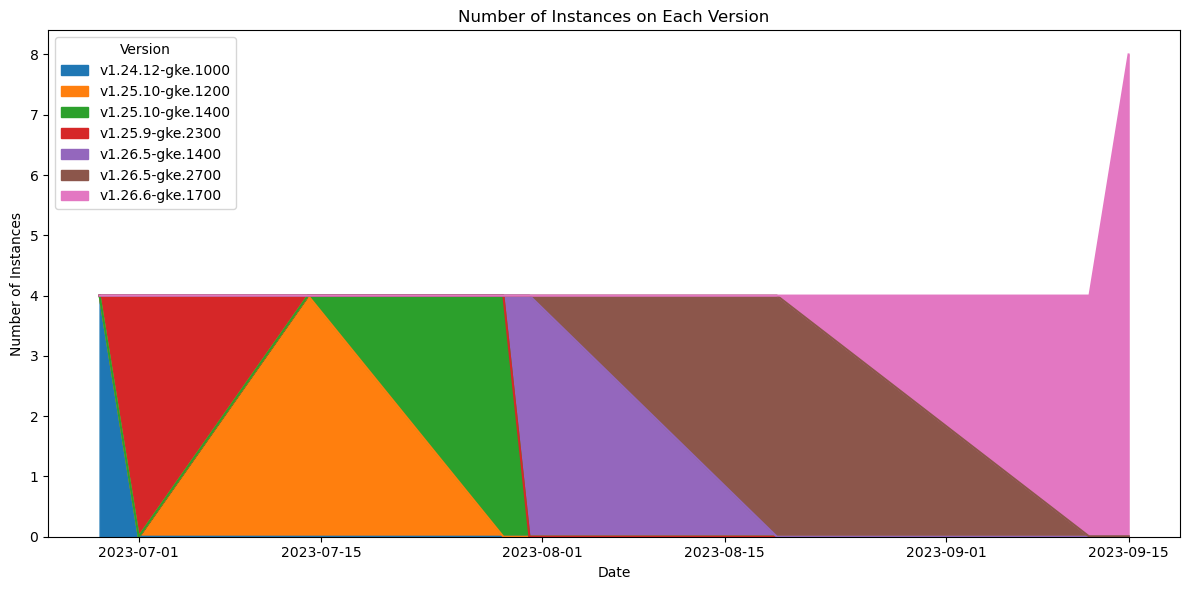

In [247]:
events_df = pd.DataFrame.from_records(events)
df = events_df
df['reportedAt'] = pd.to_datetime(df['reportedAt'])

# Create a date-only column
df['date'] = df['reportedAt'].dt.date

# Create a pivot table
pivot_df = df.pivot_table(index='date', columns='newValue', values='instanceId', aggfunc='count', fill_value=0)

# Plot the result
pivot_df.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title('Number of Instances on Each Version')
plt.ylabel('Number of Instances')
plt.xlabel('Date')
plt.legend(title='Version', loc='upper left')
plt.tight_layout()
plt.show()

In [194]:
# import numpy as np

# def events_to_timeseries(events):
df = events
df['date'] = pd.to_datetime(df['reportedAt'])


df = pd.DataFrame(data)

# Convert 'reportedAt' to datetime
df['reportedAt'] = pd.to_datetime(df['reportedAt'])
df['date'] = df['reportedAt'].dt.date

# Sort dataframe by instanceId and reportedAt
df = df.sort_values(by=['instanceId', 'reportedAt'])


# # Generate a full list of dates for each instanceId
# full_dates = pd.date_range(df['date'].min(), df['date'].max(), freq='D')
# full_dates
# all_instances = df['instanceId'].unique()
# all_instances
# df_full = pd.DataFrame({
#     'date': full_dates.repeat(len(all_instances)),
#     'instanceId': np.tile(all_instances, len(full_dates))
# })
# df_full

# # Merge the expanded dataframe with the original one
# df_merged = pd.merge(df_full, df, on=['instanceId', 'date'], how='left')

# print(df_merged.to_csv())


# # # Fill the missing newValue using forward fill for each instance
# # df_merged['newValue'] = df_merged.groupby('instanceId')['newValue'].ffill()
# # df_merged


# # # Group by date and newValue to count instances for each status per day
# # result = df_merged.groupby(['date', 'newValue'])['instanceId'].nunique().unstack(fill_value=0).reset_index()
# # result


# # # Set the date column as index
# # result.set_index('date', inplace=True)

# # # Resample to get weekly data
# # weekly_data = result.resample('W').sum()

# # # Plotting the weekly timeseries in a bar chart
# # weekly_data.plot(kind='bar', stacked=True, figsize=(12, 7))

# # plt.title("Weekly Timeseries of Instance Status")
# # plt.xlabel("Week")
# # plt.ylabel("Number of Instances")
# # plt.tight_layout()
# # plt.legend(title='Status')
# # plt.grid(axis='y')
  
# # plt.show()

,date,instanceId,newValue,reportedAt
0,2023-06-28 15:40:17.451,143421a2-38cf-4cfb-93cc-6f48d0e23bd0,,
1,2023-06-28 15:40:17.451,2Rq9aF4aVAHozi9JL8CZKkcPvqw,v1.24.12-gke.1000,2023-06-28 15:40:17.451
2,2023-06-28 15:40:17.451,d180c080-30ed-4063-aaae-f018ef73a7f6,,
3,2023-06-29 15:40:17.451,143421a2-38cf-4cfb-93cc-6f48d0e23bd0,,
4,2023-06-29 15:40:17.451,2Rq9aF4aVAHozi9JL8CZKkcPvqw,,
5,2023-06-29 15:40:17.451,d180c080-30ed-4063-aaae-f018ef73a7f6,,
6,2023-06-30 15:40:17.451,143421a2-38cf-4cfb-93cc-6f48d0e23bd0,,
7,2023-06-30 15:40:17.451,2Rq9aF4aVAHozi9JL8CZKkcPvqw,,
8,2023-06-30 15:40:17.451,d180c080-30ed-4063-aaae-f018ef73a7f6,,
9,2023-07-01 15:40:17.451,143421a2-38cf-4cfb-93cc-6f48d0e23bd0,,
10,2023-07-01 15:40:17.451,2Rq9aF4aVAHozi9JL8CZKkcPvqw,,
11,2023-07-01 15:40:17.451,d180c080-30ed-4063-aaae-f018ef73a7f6,,
12,2023-07-02 15:40:17.451,143421a2-38cf-4cfb-93cc-6f48d0e23bd0,,
13,2023-07-02 15:40:17.451,2Rq9aF4aVAHozi9JL8CZKkcPvqw,,
14,2023-07-02 15:40:17.451,d180c080-30ed-4063-aaae-f01